# # 합성곱 신경망

In [1]:
import numpy as np
import tensorflow as tf

In [12]:
class ConvolutionNetwork:
    def __init__(self, n_kernels=10, units=10, batch_size=32,learning_rate=0.1):
        self.n_kernels=n_kernels
        self.kernel_size=3
        self.optimizer=None
        self.conv_w=None
        self.conv_b=None
        self.units=units
        self.batch_size=batch_size
        self.w1=None
        self.b1=None
        self.w2=None
        self.b2=None
        self.a1=None
        self.losses=[]
        self.val_losses=[]
        self.lr=learning_rate
    def forpass(self,x):
        c_out=tf.nn.conv2d(x,self.conv_w,strides=1,padding='SAME')+self.conv_b
        r_out=tf.nn.relu(c_out)
        p_out=tf.nn.max_pool2d(r_out,ksize=2,strides=2,padding='VALID')
        f_out=tf.reshape(p_out,[x.shape[0],-1])
        z1=tf.matmul(f_out,self.w1)+self.b1
        a1=tf.nn.relu(z1)
        z2=tf.matmul(a1,self.w2)+self.b2
        return z2
    def init_weights(self,input_shape,n_classes):
        g=tf.initializers.glorot_uniform()
        self.conv_w=tf.Variable(g((3,3,1,self.n_kernels)))
        self.conv_b=tf.Variable(np.zeros(self.n_kernels),dtype=float)
        n_features=14*14*self.n_kernels
        self.w1=tf.Variable(g((n_features,self.units)))
        self.b1=tf.Variable(np.zeros(self.units),dtype=float)
        self.w2=tf.Variable(g((self.units,n_classes)))
        self.b2=tf.Variable(np.zeros(n_classes),dtype=float)
    def fit(self,x,y,epochs=100,x_val=None, y_val=None):
      
        self.init_weights(x.shape,y.shape[1])
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        for i in range (epochs):
            print('에포크',i,end='')
            batch_losses=[]
            for x_batch, y_batch in self.gen_batch(x,y):
                print('.',end='')
                self.training(x_batch,y_batch)
                batch_losses.append(self.get_loss(x_batch,y_batch))
            print()
            self.losses.append(np.mean(batch_losses))
            self.val_losses.append(self.get_loss(x_val,y_val))
    def gen_batch(self,x,y):
        
        bins=len(x)//self.batch_size
        indexes=np.random.permutation(np.arange(len(x)))
        x=x[indexes]
        y=y[indexes]
        for i in range(bins):
            start=self.batch_size*i
            end=self.batch_size*(i+1)
            yield x[start:end], y[start:end]
    def training(self,x,y):
        m=len(x)
        with tf.GradientTape() as tape:
            z=self.forpass(x)
            loss=tf.nn.softmax_cross_entropy_with_logits(y,z)
            loss=tf.reduce_mean(loss)
        weights_list=[self.conv_w,self.conv_b,self.w1,self.b1,self.w2,self.b2]
        grads=tape.gradient(loss,weights_list)
        self.optimizer.apply_gradients(zip(grads,weights_list))
    def predict(self,x):
        z=self.forpass(x)
        return np.argmax(z.numpy(),axis=1)
    def score(self,x,y):
        return np.mean(self.predict(x)==np.argmax(y,axis=1))
    def get_loss(self,x,y):
        z=self.forpass(x)
        loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y,z))
        return loss.numpy()

In [3]:
(x_train_all,y_train_all),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

In [4]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train_all,y_train_all,stratify=y_train_all,test_size=0.2,random_state=42)

In [5]:
y_train_encoded=tf.keras.utils.to_categorical(y_train)
y_val_encoded=tf.keras.utils.to_categorical(y_val)

In [6]:
x_train=x_train.reshape(-1,28,28,1)
x_val=x_val.reshape(-1,28,28,1)
x_train.shape

(48000, 28, 28, 1)

In [7]:
x_train=x_train/255
x_val=x_val/255

In [13]:
cn=ConvolutionNetwork(n_kernels=10,units=100,batch_size=128,learning_rate=0.01)
cn.fit(x_train,y_train_encoded,x_val=x_val,y_val=y_val_encoded,epochs=20)

에포크 0.......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1.......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2.........................................................................................................................................................................................................................................

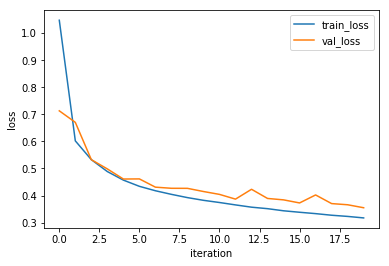

In [19]:
import matplotlib.pyplot as plt
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss','val_loss'])
plt.show()

In [16]:
cn.score(x_val,y_val_encoded)

0.87725

In [18]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense

In [20]:
conv1=tf.keras.Sequential()
conv1.add(Conv2D(10,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))

In [21]:
conv1.add(MaxPooling2D(2,2))

In [22]:
conv1.add(Flatten())

In [23]:
conv1.add(Dense(100,activation='relu'))
conv1.add(Dense(10,activation='softmax'))

In [24]:
conv1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [25]:
conv1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [28]:
history=conv1.fit(x_train,y_train_encoded,epochs=20,validation_data=(x_val,y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 21s 438us/sample - loss: 0.4441 - accuracy: 0.8439 - val_loss: 0.3315 - val_accuracy: 0.8823
Epoch 2/20
48000/48000 [==============================] - 19s 405us/sample - loss: 0.3062 - accuracy: 0.8909 - val_loss: 0.2981 - val_accuracy: 0.8956
Epoch 3/20
48000/48000 [==============================] - 19s 404us/sample - loss: 0.2613 - accuracy: 0.9040 - val_loss: 0.2656 - val_accuracy: 0.9053
Epoch 4/20
48000/48000 [==============================] - 19s 403us/sample - loss: 0.2289 - accuracy: 0.9153 - val_loss: 0.2574 - val_accuracy: 0.9061
Epoch 5/20
48000/48000 [==============================] - 19s 405us/sample - loss: 0.2015 - accuracy: 0.9248 - val_loss: 0.2557 - val_accuracy: 0.9081
Epoch 6/20
48000/48000 [==============================] - 19s 403us/sample - loss: 0.1812 - accuracy: 0.9325 - val_loss: 0.2492 - val_accuracy: 0.9115
Epoch 7/20
48000/48000 [====================

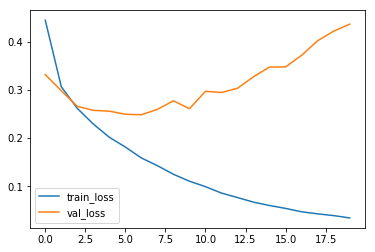

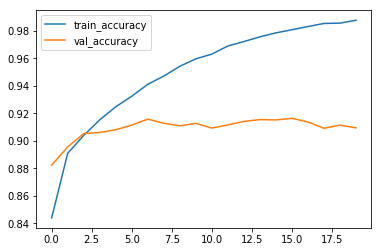

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss','val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

In [31]:
from tensorflow.keras.layers import Dropout

conv2=tf.keras.Sequential()
conv2.add(Conv2D(10,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
conv2.add(MaxPooling2D(2,2))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100,activation='relu'))
conv2.add(Dense(10,activation='softmax'))
conv2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

In [33]:
conv2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=conv2.fit(x_train,y_train_encoded,epochs=20,validation_data=(x_val,y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 24s 501us/sample - loss: 0.5163 - accuracy: 0.8143 - val_loss: 0.3603 - val_accuracy: 0.8774
Epoch 2/20
48000/48000 [==============================] - 22s 459us/sample - loss: 0.3724 - accuracy: 0.8651 - val_loss: 0.3032 - val_accuracy: 0.8941
Epoch 3/20
48000/48000 [==============================] - 22s 459us/sample - loss: 0.3317 - accuracy: 0.8787 - val_loss: 0.2815 - val_accuracy: 0.8976
Epoch 4/20
48000/48000 [==============================] - 22s 457us/sample - loss: 0.3052 - accuracy: 0.8873 - val_loss: 0.2670 - val_accuracy: 0.9027
Epoch 5/20
48000/48000 [==============================] - 22s 457us/sample - loss: 0.2842 - accuracy: 0.8937 - val_loss: 0.2511 - val_accuracy: 0.9071
Epoch 6/20
48000/48000 [==============================] - 22s 457us/sample - loss: 0.2667 - accuracy: 0.9005 - val_loss: 0.2428 - val_accuracy: 0.9115
Epoch 7/20
48000/48000 [====================

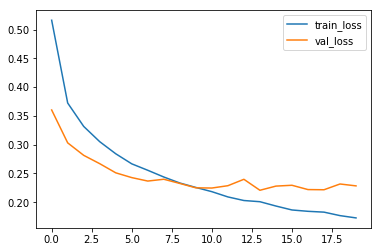

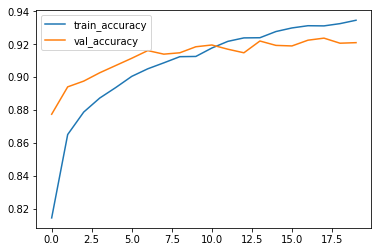

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss','val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy','val_accuracy'])
plt.show()